In [1]:
import numpy as np
import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import Normalization
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame, read_csv

In [3]:
df = pd.read_csv("life.csv")

# clean up data a bit
df.fillna(0, inplace=True)

# replace dates with sequential number
# will updates this when annual recurrence happens (could be interesting)
df["Day"] = range(1, 1+len(df))

# pre-process: change mood to 1-5 rating
mood = df["Mood Evening"]
mood = np.where(mood < 3, 1, mood)
mood = np.where((mood == 3) | ( mood == 4), 2, mood)
mood = np.where((df["Mood Evening"] == 5) | ( mood == 6), 3, mood)
mood = np.where((mood == 7) | ( mood == 8), 4,mood)
mood = np.where((mood == 9) | ( mood == 10), 5, mood)

df["Mood Evening"] = mood

#move label to end
df = df[[c for c in df if c not in ["Mood Morning", "Mood Evening"]] + ["Mood Morning", "Mood Evening"]]

# split in training and dev set
validation_raw = df.sample(frac=0.2, random_state=1)
train_raw = df.drop(validation_raw.index)

print(f"Found {len(train_raw)} samples for training and {len(validation_raw)} for validation.")



Found 292 samples for training and 73 for validation.


In [4]:
train_data     = np.array(train_raw)[:,1:22].astype(np.float32)
train_labels   = np.array(train_raw)[:,-1].astype(np.float32)

test_data      = np.array(train_raw)[:,1:22].astype(np.float32)
test_labels    = np.array(train_raw)[:,-1].astype(np.float32)


In [5]:
print(train_data.shape)
print(train_labels.shape)

(292, 21)
(292,)


4.0

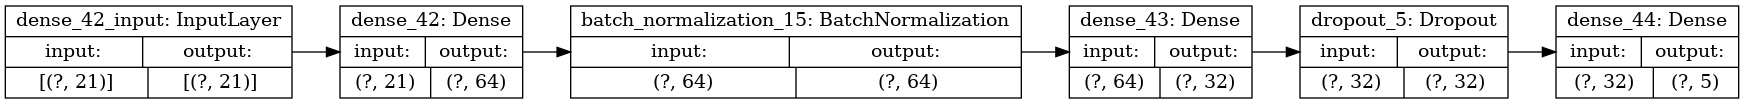

In [138]:
model = tf.keras.models.Sequential()


model.add( tf.keras.layers.Dense(64, input_shape=[21], activation="relu"))
model.add( tf.keras.layers.BatchNormalization())
model.add( tf.keras.layers.Dense(32, activation="relu"))
model.add( tf.keras.layers.Dropout(0.1))
model.add( tf.keras.layers.Dense(5, activation="softmax"))


opt = keras.optimizers.Adam(learning_rate=0.001)

model.compile(  
    optimizer=opt,
    loss="sparse_categorical_crossentropy", 
    metrics=["accuracy"]
    )

# plot a horizontal graph of the model and write it to disk
keras.utils.plot_model(model, show_shapes=True,rankdir="LR", to_file="model.png")

In [139]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 64)                1408      
_________________________________________________________________
batch_normalization_15 (Batc (None, 64)                256       
_________________________________________________________________
dense_43 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_44 (Dense)             (None, 5)                 165       
Total params: 3,909
Trainable params: 3,781
Non-trainable params: 128
_________________________________________________________________


In [140]:
# train the model
history = model.fit(train_data,train_labels, epochs=400, batch_size=40, validation_data=(test_data,test_labels), verbose =1 )


===========================] - 0s 3ms/step - loss: 0.2753 - accuracy: 0.8870 - val_loss: 0.2639 - val_accuracy: 0.9212
Epoch 260/400
8/8 [==============================] - 0s 3ms/step - loss: 0.2886 - accuracy: 0.8836 - val_loss: 0.2623 - val_accuracy: 0.9144
Epoch 261/400
8/8 [==============================] - 0s 3ms/step - loss: 0.2882 - accuracy: 0.8973 - val_loss: 0.2617 - val_accuracy: 0.9110
Epoch 262/400
8/8 [==============================] - 0s 3ms/step - loss: 0.2810 - accuracy: 0.8938 - val_loss: 0.2540 - val_accuracy: 0.9144
Epoch 263/400
8/8 [==============================] - 0s 3ms/step - loss: 0.2783 - accuracy: 0.9075 - val_loss: 0.2452 - val_accuracy: 0.9212
Epoch 264/400
8/8 [==============================] - 0s 3ms/step - loss: 0.2691 - accuracy: 0.8938 - val_loss: 0.2438 - val_accuracy: 0.9281
Epoch 265/400
8/8 [==============================] - 0s 3ms/step - loss: 0.3020 - accuracy: 0.8870 - val_loss: 0.2417 - val_accuracy: 0.9281
Epoch 266/400
8/8 [================

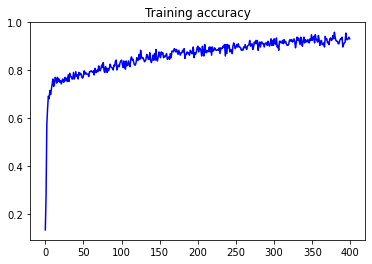

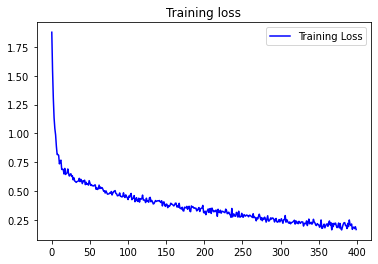

In [142]:
import matplotlib 
from matplotlib import pyplot as plt

accuracy = history.history["accuracy"]
loss = history.history["loss"]

epochs = range(len(accuracy))
plt.plot(epochs,accuracy, "b",label="Training accuracy")
plt.title("Training accuracy")
plt.figure()

plt.plot(epochs, loss, "b",label="Training Loss")
plt.title("Training loss")
plt.legend()
plt.show()

In [2]:
#model = tf.keras.models.load_model("model.h5")

In [12]:
#model.save("model.h5")
#model = tf.keras.models.load_model("model.h5")

### Example on how to do a prediction for a new day
sample = [( 
            0,  #Max Pullup
            0,  
            0,  
            0,  
            0,  #Running
            0,  #Walk
            0,  #Bike
            0,  #Swim
            0,  #Tennis
            0,  #Violin
            0,  #Reading
            0,  #Study
            0,  #Dancing
            0,  
            0,  #Social
            66, #Weight
            0,  
            0,  
            8,  #Sleep
            0,  #Spent
            0   #Other
            )]

pred = model.predict(sample) 
print("Mood Evening predicted:" + str(np.argmax(pred)+1))